**Подключение библиотек**

In [1]:
import numpy as np
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt

**Препроцессинг данных**

In [2]:
#путь к папке с данными
path=os.getcwd()+'\oil_gas_train_test'

In [3]:
files=os.listdir(path)

In [4]:
df= pd.read_excel(os.path.join(path, 'AMPY.xlsx') ,engine='openpyxl')

Извлечение revenue  и operating income

In [5]:
list_dfs_train=[]
list_dfs_test=[]
for i, filename in enumerate(files):
    df= pd.read_excel(os.path.join(path, filename) ,engine='openpyxl')
    revenue = df.iloc[28].tolist()[9:51]
    date = df.iloc[27].tolist()[9:51]
    op_in = df.iloc[42].tolist()[9:51]
    company_name = [filename]*42
    company_number = [i]*42
    #create dataframe with shift values
     
    df_result_part = pd.DataFrame({'date': date, 'company_name' : company_name, 'company_number': company_number, \
                                   'op_in':op_in,'revenue':revenue})    
    train_data_part = df_result_part.iloc[:-4, :]
    test_data_part = df_result_part.iloc[-4:, :]
    list_dfs_train.append(train_data_part)
    list_dfs_test.append(test_data_part)


train = pd.concat(list_dfs_train,ignore_index=True)
test  = pd.concat(list_dfs_test, ignore_index=True)

**EDA**

In [8]:
full=pd.concat([train,test])

In [9]:
full.to_csv('collected_data.xlxs')

In [12]:
full.reset_index(inplace=True)

**Динамика выручки и операционного дохода**

Операционный доход

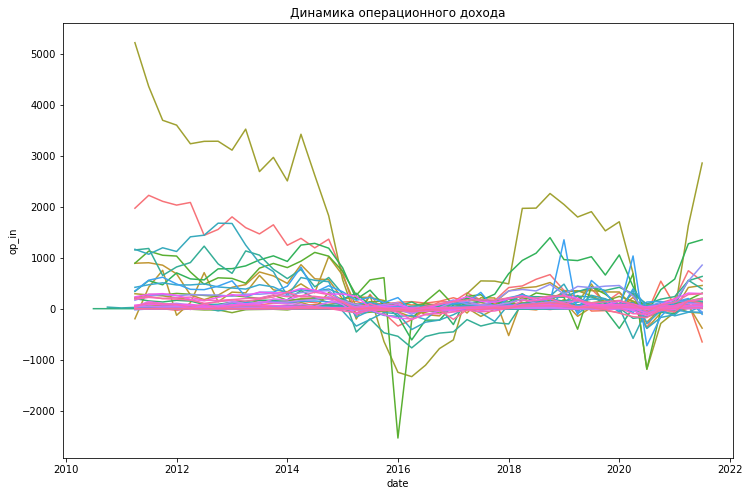

In [14]:
#group_date=full.groupby('date',as_index=False).agg({'op_in':'sum','revenue':'sum'})
fig, ax = plt.subplots(figsize=(12,8))
sns.lineplot(x="date", y="op_in",
             hue="company_name",
             data=full,legend=False, ax=ax)

plt.title('Динамика операционного дохода')
plt.show()

Выручка

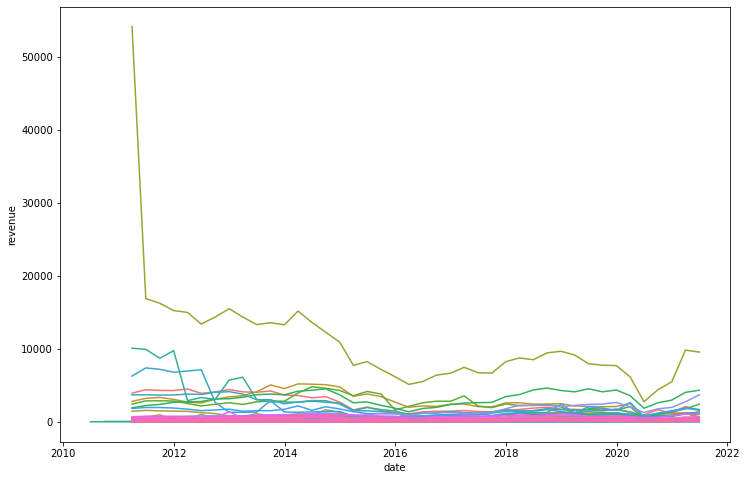

In [15]:
figure=plt.figure(figsize=(12,8))
sns.lineplot(x="date", y="revenue",
             hue="company_name",
             data=full,legend=False);

Заметна компания с наиболее волатильной выручкой и операционным доходом, "COP":

In [16]:
full.query("date=='2011-03-31'").sort_values('revenue',ascending=False).head()

,index,date,company_name,company_number,op_in,revenue
456,456,2011-03-31,COP.xlsx,12,5224.999936,54174.998528
912,912,2011-03-31,HES.xlsx,24,1154.000000,10085.000192
1216,1216,2011-03-31,MUR.xlsx,32,420.136992,6266.009088
38,38,2011-03-31,APA.xlsx,1,1974.000000,3921.999872
1140,1140,2011-03-31,MRO.xlsx,30,1167.000064,3687.000064


In [17]:
full.query("date=='2011-03-31'").sort_values('op_in',ascending=False).head()

,index,date,company_name,company_number,op_in,revenue
456,456,2011-03-31,COP.xlsx,12,5224.999936,54174.998528
38,38,2011-03-31,APA.xlsx,1,1974.000000,3921.999872
1140,1140,2011-03-31,MRO.xlsx,30,1167.000064,3687.000064
912,912,2011-03-31,HES.xlsx,24,1154.000000,10085.000192
304,304,2011-03-31,CHK.xlsx,8,893.000000,2793.999872


**Построение распределений**

Операционный доход

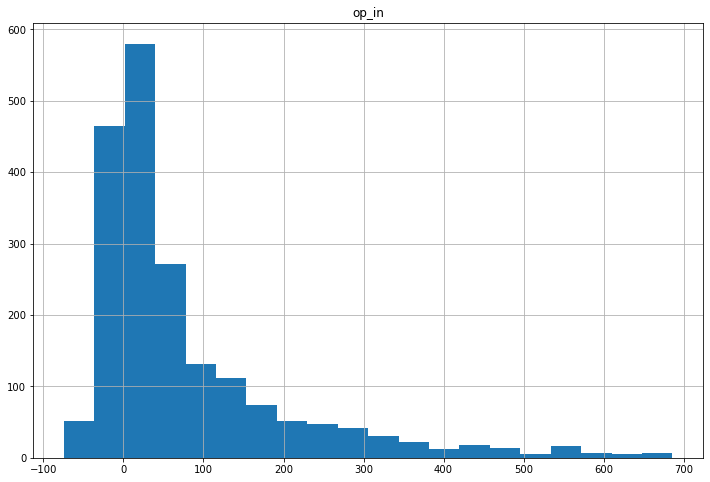

In [18]:
full.op_in.to_frame().query("op_in.quantile(0.05)<op_in<op_in.quantile(0.95)").hist(figsize=(12,8),bins=20);

Выручка

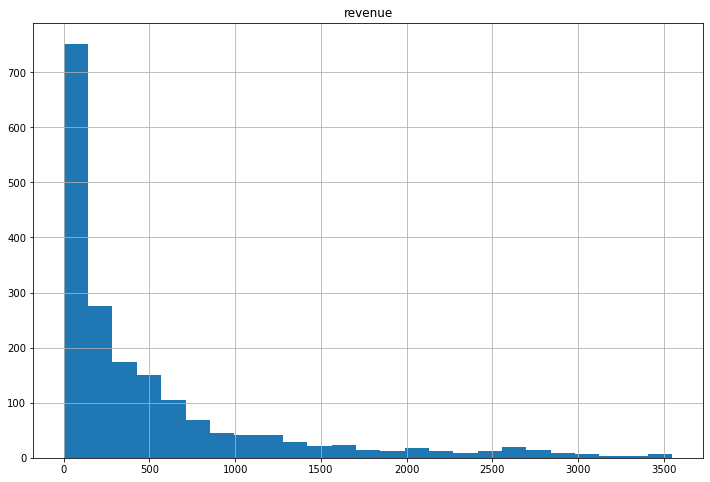

In [19]:
full.revenue.to_frame().query("revenue.quantile(0.05)<revenue<revenue.quantile(0.95)").hist(figsize=(12,8),bins=25);

In [20]:
full.describe()

,index,company_number,op_in,revenue
count,2184.000000,2184.000000,2184.000000,2184.000000
mean,903.309524,25.500000,131.446843,791.418660
std,601.862211,15.011768,404.744447,2045.997767
min,0.000000,0.000000,-2540.000000,-36.210000
25%,337.750000,12.750000,0.000000,50.018000
50%,883.500000,25.500000,28.286000,206.969496
75%,1429.250000,38.250000,125.758500,655.233248
max,1975.000000,51.000000,5224.999936,54174.998528


Пропущенные значения в основном содержатся в начале таймлайна:

In [21]:
full['date'].to_frame().merge( (full[['op_in','revenue']]==0)*1,left_index=True,right_index=True)\
    .groupby('date').agg({'op_in':'sum','revenue':'sum'}).sort_values(['op_in','revenue'],ascending=False)\
    .rename(columns={'op_in':'zero values as op_in','revenue':'zero values as revenue'}).head(15)

,zero values as op_in,zero values as revenue
date,,
2011-03-31,13,13
2011-06-30,13,13
2011-09-30,12,12
2011-12-31,11,11
2012-03-31,10,10
2012-06-30,10,10
2012-09-30,10,10
2012-12-31,10,10
2013-03-31,9,9


Всего пропущенных (нулевых) значений:

In [22]:
((full[['op_in','revenue']]==0)*1).sum()

op_in      203
revenue    203
dtype: int64

Достаточно сильная корреляция между двумя целевыми признаками:

In [23]:
full[['op_in','revenue']].corr()

,op_in,revenue
op_in,1.000000,0.781094
revenue,0.781094,1.000000


Добавление макроданных Идеи: цена на нефть, газ, индекс акций (Dow John's, etc), ВВП США, экспорт нефти США, добыча нефти